###  Importing Library

In [65]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from Tools.scripts.stable_abi import generators
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR


#  1 Hyperparameters

In [66]:
batch_size = 64
image_size = 64
nz = 100

lrD = 0.0002      # LR untuk Discriminator
lrG = 0.00025      # LR untuk Generator
beta1 = 0.5       # Beta 1 tetep sama dari 0.5 -> 0.5
beta2 = 0.8     # Beta 2 naikan dari 0.7 -> 0.8

num_epochs = 20 # EPOCHS dinaikan dari 10 -> 20

r1_gamma = 9.0 # r1_gamma dinaikan dari 7.0 -> 8.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memeriksa apakah CUDA tersedia
print(torch.cuda.is_available())

# Jika True, berarti GPU Anda bisa digunakan oleh PyTorch
# Nama GPU (untuk device index 0)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(torch.version.cuda)


True
NVIDIA GeForce GTX 1060 6GB
11.8


# 2. Dataset & Augmentations

In [67]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    # RandomHorizontalFlip 50% tetap
    transforms.RandomHorizontalFlip(p=0.5),
    # RandomRotation degrees=10 (daripada 15)
    transforms.RandomRotation(degrees=10),
    # ColorJitter diperlemah
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

data_dir = r"dataset-path-here"
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 3. Definisi Model DCGAN (Generator & Discriminator)

In [68]:
class Generator(nn.Module):
    def __init__(self, nz, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [69]:
class Discriminator(nn.Module):
    # ndf=32 (lebih kecil daripada 64)
    def __init__(self, nc=3, ndf=32):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

netG = Generator(nz=nz, ngf=64).to(device)
netD = Discriminator(nc=3, ndf=32).to(device)


# 4. Loss, Optimizer, Scheduler

In [70]:
criterion = nn.BCELoss()

# LR untuk Discriminator diturunkan ke 0.0001
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))

schedulerD = StepLR(optimizerD, step_size=10, gamma=0.5)
schedulerG = StepLR(optimizerG, step_size=10, gamma=0.5)

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# 5. Training Loop (with R1 Regularization)

In [71]:
# Logging
lossD_history = []
lossG_history = []

#Logging Loss *per-epoch*
lossD_epoch = []
lossG_epoch = []

In [72]:
for epoch in range(num_epochs):
    epoch_lossD = 0.0
    epoch_lossG = 0.0
    total_batches = 0

    for i, (imgs, _) in enumerate(dataloader):
        b_size = imgs.size(0)
        total_batches += 1

        # (A) Train Discriminator
        netD.zero_grad()
        real_imgs = imgs.to(device)
        real_imgs.requires_grad_(True)

        label_real = torch.full((b_size,), 1.0, device=device)
        output_real = netD(real_imgs).view(-1)
        lossD_real = criterion(output_real, label_real)
        lossD_real.backward(retain_graph=True)

        # R1 penalty (r1_gamma=1.0)
        grad_real = torch.autograd.grad(
            outputs=output_real.sum(),
            inputs=real_imgs,
            create_graph=True
        )[0]
        r1_penalty = r1_gamma * grad_real.pow(2).view(b_size, -1).sum(1).mean()
        r1_penalty.backward()

        real_imgs.requires_grad_(False)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)
        label_fake = torch.full((b_size,), 0.0, device=device)
        output_fake = netD(fake_imgs.detach()).view(-1)
        lossD_fake = criterion(output_fake, label_fake)
        lossD_fake.backward()

        lossD_total = lossD_real + lossD_fake + r1_penalty
        optimizerD.step()

        # (B) Train Generator
        netG.zero_grad()
        label_fake_forG = torch.full((b_size,), 1.0, device=device)
        output_fake_forG = netD(fake_imgs).view(-1)
        lossG = criterion(output_fake_forG, label_fake_forG)
        lossG.backward()
        optimizerG.step()

        epoch_lossD += lossD_total.item()
        epoch_lossG += lossG.item()

        # Log per-100 batch
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"LossD: {lossD_total.item():.4f}, LossG: {lossG.item():.4f}")

    # Rata-rata Loss per epoch
    avg_lossD = epoch_lossD / total_batches
    avg_lossG = epoch_lossG / total_batches
    lossD_epoch.append(avg_lossD)
    lossG_epoch.append(avg_lossG)

    # Step the scheduler each epoch
    schedulerD.step()
    schedulerG.step()

    # Log per-epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] | LossD: {avg_lossD:.4f} | LossG: {avg_lossG:.4f} | "
          f"LR_D: {schedulerD.get_last_lr()[0]:.6f} | LR_G: {schedulerG.get_last_lr()[0]:.6f}")

    # Save sample image each epoch
    with torch.no_grad():
        fake_sample = netG(fixed_noise).detach().cpu()
    grid = make_grid(fake_sample, nrow=8, normalize=True)
    os.makedirs("samples", exist_ok=True)
    save_image(grid, f"samples/epoch_{epoch+1}.png")
    print(f"Sample image saved: samples/epoch_{epoch+1}.png")

Epoch [1/20] Batch [0/1483] LossD: 2.2286, LossG: 1.5327
Epoch [1/20] Batch [100/1483] LossD: 1.8359, LossG: 1.1285
Epoch [1/20] Batch [200/1483] LossD: 1.2512, LossG: 1.1127
Epoch [1/20] Batch [300/1483] LossD: 1.6058, LossG: 0.8867
Epoch [1/20] Batch [400/1483] LossD: 1.3214, LossG: 1.1718
Epoch [1/20] Batch [500/1483] LossD: 1.2488, LossG: 1.5923
Epoch [1/20] Batch [600/1483] LossD: 1.3338, LossG: 1.1952
Epoch [1/20] Batch [700/1483] LossD: 1.2962, LossG: 1.2039
Epoch [1/20] Batch [800/1483] LossD: 1.3142, LossG: 1.1179
Epoch [1/20] Batch [900/1483] LossD: 1.4903, LossG: 1.0446
Epoch [1/20] Batch [1000/1483] LossD: 1.3923, LossG: 1.0691
Epoch [1/20] Batch [1100/1483] LossD: 1.4481, LossG: 0.8839
Epoch [1/20] Batch [1200/1483] LossD: 1.3295, LossG: 0.9427
Epoch [1/20] Batch [1300/1483] LossD: 1.3294, LossG: 1.0075
Epoch [1/20] Batch [1400/1483] LossD: 1.3540, LossG: 1.0328
Epoch [1/20] | LossD: 1.3667 | LossG: 1.2343 | LR_D: 0.000200 | LR_G: 0.000250
Sample image saved: samples/epoch

# 8. Plot Loss vs. Epoch

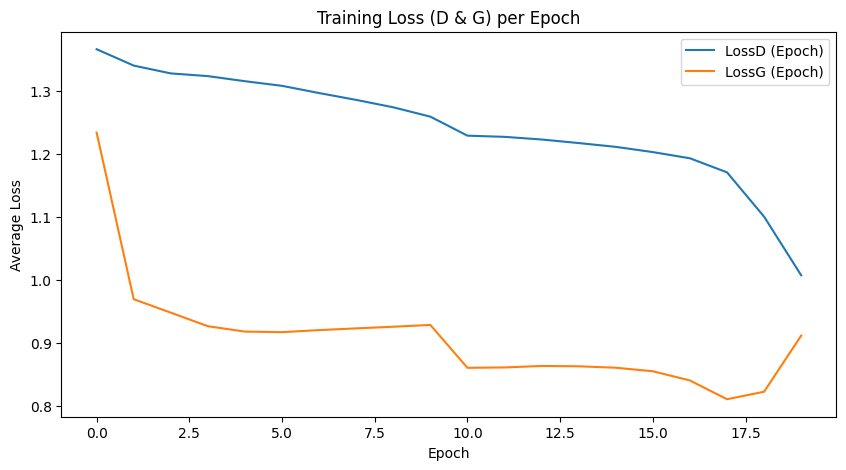

Plot saved: training_loss_epoch_plot.png


In [73]:
plt.figure(figsize=(10,5))
plt.title("Training Loss (D & G) per Epoch")
plt.plot(lossD_epoch, label="LossD (Epoch)")
plt.plot(lossG_epoch, label="LossG (Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.savefig("training_loss_epoch_plot.png")
plt.show()

print("Plot saved: training_loss_epoch_plot.png")

# 9. saving model

In [77]:
model_dir = r"dataset-path-here"
os.makedirs(model_dir, exist_ok=True)
gen_final_path = os.path.join(model_dir, "Generator_final.pth")
dis_final_path = os.path.join(model_dir, "Discriminator_final.pth")

torch.save(netG.state_dict(), gen_final_path)
torch.save(netD.state_dict(), dis_final_path)

print(f"Generator saved to {gen_final_path}")
print(f"Discriminator saved to {dis_final_path}")

print("Training Finished.")


Generator saved to C:\Users\dawwi\OneDrive\Desktop\tubes_Generativ_AI\saved_models\Generator_final.pth
Discriminator saved to C:\Users\dawwi\OneDrive\Desktop\tubes_Generativ_AI\saved_models\Discriminator_final.pth
Training Finished.


# 10. Load model FID

In [101]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from scipy import linalg
from torchvision.models import inception_v3

# Definisikan arsitektur Generator terlebih dahulu
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.main = nn.Sequential(
            # Input adalah Z, masuk ke convolution
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model weights
generator_state_dict = torch.load(
    r"dataset-path-here",
    map_location=device
)

# Initialize model and load weights
generator = Generator()
generator.load_state_dict(generator_state_dict)
generator = generator.to(device)
generator.eval()

def calculate_fid(real_images, generator_model, num_samples=1000, batch_size=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = torch.nn.Identity()
    inception_model = inception_model.to(device)
    inception_model.eval()

    # Prepare transforms
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    def get_activations(images):
        activations = []
        with torch.no_grad():
            for img_batch in DataLoader(images, batch_size=batch_size):
                if isinstance(img_batch, (tuple, list)):
                    img_batch = img_batch[0]  # Extract images from (images, labels) tuple
                img_batch = img_batch.to(device)
                img_batch = preprocess(img_batch)
                act = inception_model(img_batch)
                activations.append(act.cpu().numpy())
        return np.concatenate(activations, axis=0)

    # Get real image activations
    real_activations = get_activations(real_images)

    # Generate fake images
    generator_model.eval()
    fake_images = []
    with torch.no_grad():
        for _ in range(0, num_samples, batch_size):
            batch_size_i = min(batch_size, num_samples - len(fake_images))
            z = torch.randn(batch_size_i, generator_model.z_dim, 1, 1).to(device)
            fake_batch = generator_model(z)
            fake_images.append(fake_batch.cpu())
    fake_images = torch.cat(fake_images, dim=0)
    fake_activations = get_activations(fake_images)

    # Calculate statistics
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)

    mu_fake = np.mean(fake_activations, axis=0)
    sigma_fake = np.cov(fake_activations, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = linalg.sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)

    return fid_score

# Setup dataset dan transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset menggunakan ImageFolder
real_dataset = datasets.ImageFolder(
    root=r"dataset-path-here",
    transform=transform
)
real_loader = DataLoader(real_dataset, batch_size=64, shuffle=True)

# Ambil batch pertama dari real images
try:
    real_images, _ = next(iter(real_loader))

    # Hitung FID
    fid_score = calculate_fid(real_images, generator)
    print(f"FID Score: {fid_score}")

except Exception as e:
    print(f"Error occurred: {str(e)}")

C:\Users\dawwi\AppData\Local\Temp\ipykernel_4796\3132799399.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state_dict = torch.load(


FID Score: 112.187290547179
